# DDPM Coursework Part 2 - Ben Hallett


## Problem 1 - Exploritory Data analysis

## 1.1

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import scipy.integrate as spi
from typing import Tuple, List, Callable
from tqdm import tqdm
import torch
import torch.nn as nn

In [24]:
# global experiment parameters
SAMPLE_RATE = 100 # Hz

In [25]:
# loading data
data_dict = dict(np.load(r'data\\coursework-2024+25-part2.npz'))
data_all = [it[1] for it in data_dict.items()]


In [26]:
print(data_dict.keys())
print(data_dict['x'].shape)
print(data_dict['u'].shape)


dict_keys(['x', 'u'])
(108, 2000)
(108, 2000)


Plotting timeseries data 

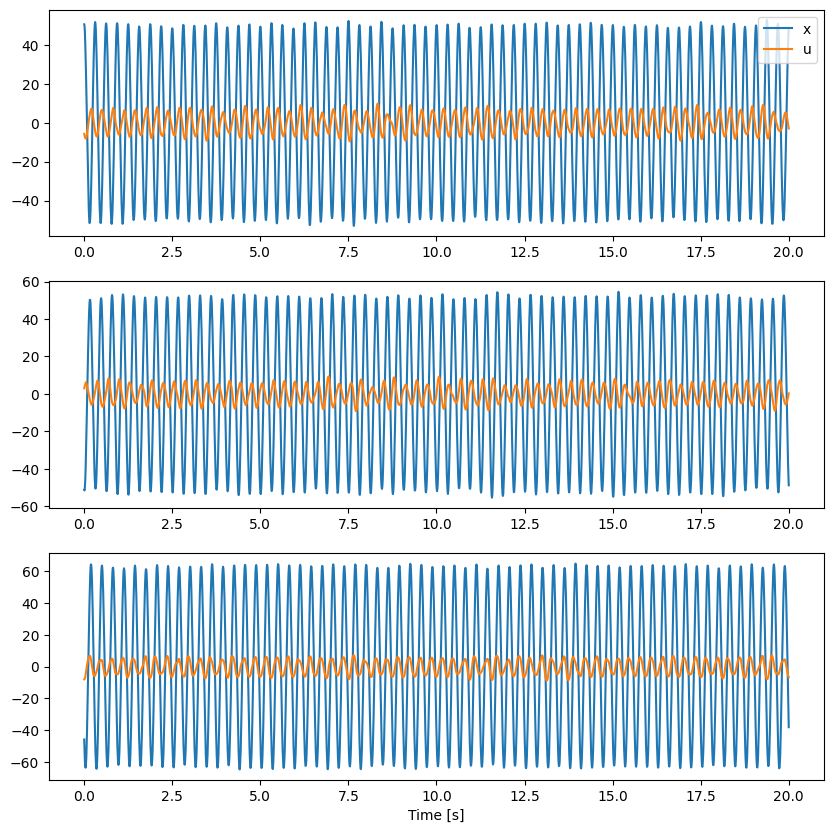

In [27]:
inds = np.random.choice(data_dict['x'].shape[0], 3, replace=False)

fig, axs = plt.subplots(3, 1, figsize=(10, 10))
t = np.linspace(0, data_dict['x'].shape[1] / SAMPLE_RATE, data_dict['x'].shape[1])
for i, ind in enumerate(inds):
    axs[i].plot(t, data_dict['x'][ind], label='x')
    axs[i].plot(t, data_dict['u'][ind], label='u')
    
axs[0].legend()
axs[2].set_xlabel('Time [s]')
plt.show()
    


## 1.2
calculating standard deviation of each timeseries and plotting std(x) against std(u)

Text(0, 0.5, 'std(u)')

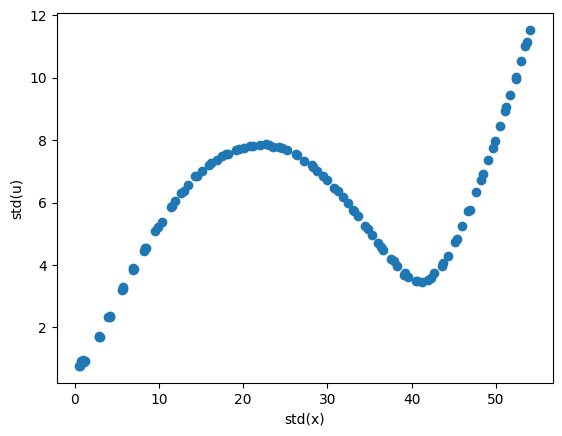

In [28]:
X = data_dict['x']
U = data_dict['u']

X_std = np.std(X, axis=1)
U_std = np.std(U, axis=1)

plt.plot(X_std, U_std, 'o')
plt.xlabel('std(x)')
plt.ylabel('std(u)')

We see that there appears to be a cubic function mapping std(x) to std(u) but there is no function mapping std(u) to std(x). So the force amplitude can be determined from the displacement amplitude, but not vice versa. Additionally we see that, perhaps somewhat unexpectedly the force amplitude actually decreases past a certain displacement amplitude, before increasing again.

## 1.3
Truncating each time series to the first 200 measurements

In [29]:
X = X[:, :200]
U = U[:, :200]

print(X.shape, U.shape)

(108, 200) (108, 200)


## 1.4
To normalise so that each timeseries has a maximum amplitude of one we can do the following 

In [30]:
X_max = np.max(X.flatten())
U_max = np.max(U.flatten())

X = X / X_max
U = U / U_max

assert np.max(X.flatten()) == 1
assert np.max(U.flatten()) == 1

print(X.shape, U.shape)

(108, 200) (108, 200)


## Problem 2 - Echo State Networks

## 2.1

In [31]:
X_sample = X[27, :].squeeze()
U_sample = U[27, :].squeeze()

sample_std = np.std(X_sample*X_max)
assert sample_std >= 42, f'sample std = {sample_std} is too low'

# lets stack the data for ease of use
sample = np.vstack([X_sample, U_sample])
print(sample.shape)

# lets do a 60-40 train test split
split_pos = round(0.6*X_sample.shape[0])
train_data = sample[:, :split_pos]
test_data = sample[:, split_pos:]

print(train_data.shape, test_data.shape)


(2, 200)
(2, 120) (2, 80)


## 2.2

ESN Code from workshop

In [32]:
def create_reservoir(size, in_size=1, spectral_radius=0.9):
    """
    Create a reservoir with the given size and spectral radius.

    Parameters
    ----------
    size : int
        The number of neurons in the reservoir.
    in_size : int, optional (default is 1)
        The number of input neurons.
    spectral_radius : float, optional (default is 0.9)
        The desired spectral radius of the reservoir weight matrix.

    Returns
    -------
    W : ndarray
        The reservoir weight matrix.
    Win : ndarray
        The input weight matrix.
    """
    # Create a random reservoir matrix with elements in [-0.5, 0.5]
    W = np.random.rand(size, size) - 0.5
    # Set diagonal elements to zero (no self feedback)
    np.fill_diagonal(W, 0)
    # Scale the matrix to have spectral radius = spectral_radius
    max_eig = np.max(np.abs(np.linalg.eigvals(W)))
    W *= spectral_radius / max_eig
    # Create a random input matrix with elements in [-0.5, 0.5]
    Win = np.random.rand(size, in_size) - 0.5
    return W, Win

def run_reservoir(W, Win, u, x = None):
    """
    Run the reservoir with the given input.

    Parameters
    ----------
    W : ndarray
        The reservoir weight matrix.
    Win : ndarray
        The input weight matrix.
    u : ndarray
        The input signal matrix.
    x : ndarray, optional
        The initial state vector of the reservoir. If not provided, it is set to zero.

    Returns
    -------
    all_x : ndarray
        The state vectors of the reservoir at each time step.
    """
    # Initialize the state vector if needed
    if x is None:
        x = np.zeros(W.shape[0])
    # Run the reservoir and store the state vectors
    all_x = np.zeros((u.shape[0], W.shape[0]))
    for i in range(u.shape[0]):
        # Evaluate the reservoir (hidden layer) at the current time step
        x = np.tanh(np.dot(W, x) + np.dot(Win, u[i, :]))
        all_x[i, :] = x
    return all_x

def train_reservoir(all_x, y):
    """
    Train the output weights of the reservoir.

    Parameters
    ----------
    all_x : ndarray
        The state vectors of the reservoir at each time step.
    y : ndarray
        The target output signal matrix.

    Returns
    -------
    Wout : ndarray
        The output weight matrix.
    """
    # Solve for the output weights using least squares
    return np.linalg.lstsq(all_x, y, rcond=None)[0]

def predict_reservoir(Wout, W, Win, u):
    """
    Predict the output signal of the reservoir.

    Parameters
    ----------
    Wout : ndarray 
        The output weight matrix.
    W : ndarray
        The reservoir weight matrix.
    Win : ndarray
        The input weight matrix.
    u : ndarray
        The input signal matrix.

    Returns
    -------
    y : ndarray
        The predicted output signal matrix.
    """
    # Initialize the state vector
    x = np.zeros(W.shape[0])
    # Run the reservoir and predict the output
    y = np.zeros((u.shape[0], Wout.shape[1]))
    for i in range(u.shape[0]):
        # Evaluate the reservoir (hidden layer) at the current time step
        x = np.tanh(np.dot(W, x) + np.dot(Win, u[i, :]))
        y[i, :] = np.dot(Wout.T, x)
    return y

creating and training an initial ESN on the training data. Because we saw that the amplitude of u appears to be a function of x, it makes sense to use a single input x and train the network to predict x and u at the next timestep

In [33]:
def train_esn(size, spectral_radius, train_data, test_data):
    """
    Train and predict using an Echo State Network (ESN) with the given parameters.

    args:
    ------
    size : int
        The number of neurons in the reservoir.
    spectral_radius : float
        The desired spectral radius of the reservoir weight matrix
    train_data : ndarray
        The training data to use for training the ESN, with shape (n_features, n_samples)
    test_data : ndarray
        The test data to evaluate the trained ESN, with shape (n_features, n_samples)
    
    returns:
    --------
    W_in : ndarray
        The input weight matrix
    W : ndarray
        The reservoir weight matrix
    W_out : ndarray
        The output weight matrix
    """
    # creating the reservoir with input size 2, corresponding to x 
    W, W_in = create_reservoir(size=size, in_size=2, spectral_radius=spectral_radius)
    # running the reservoir with the training data to generate hidden layer states
    hidden = run_reservoir(W, W_in, train_data[:, :-1].T)
    # time shifted by 1 so that the network learns to predict the next state
    W_out = train_reservoir(hidden, train_data[:, 1:].T) 

    return W_in, W, W_out

In [34]:
# training the ESN
W_in, W, W_out = train_esn(100, 0.9, train_data, test_data)

# making training and test predictions
train_preds = predict_reservoir(W_out, W, W_in, train_data[:, :-1].T)
test_preds = predict_reservoir(W_out, W, W_in, test_data[:, :-1].T)

now let's generate training and testing predictions

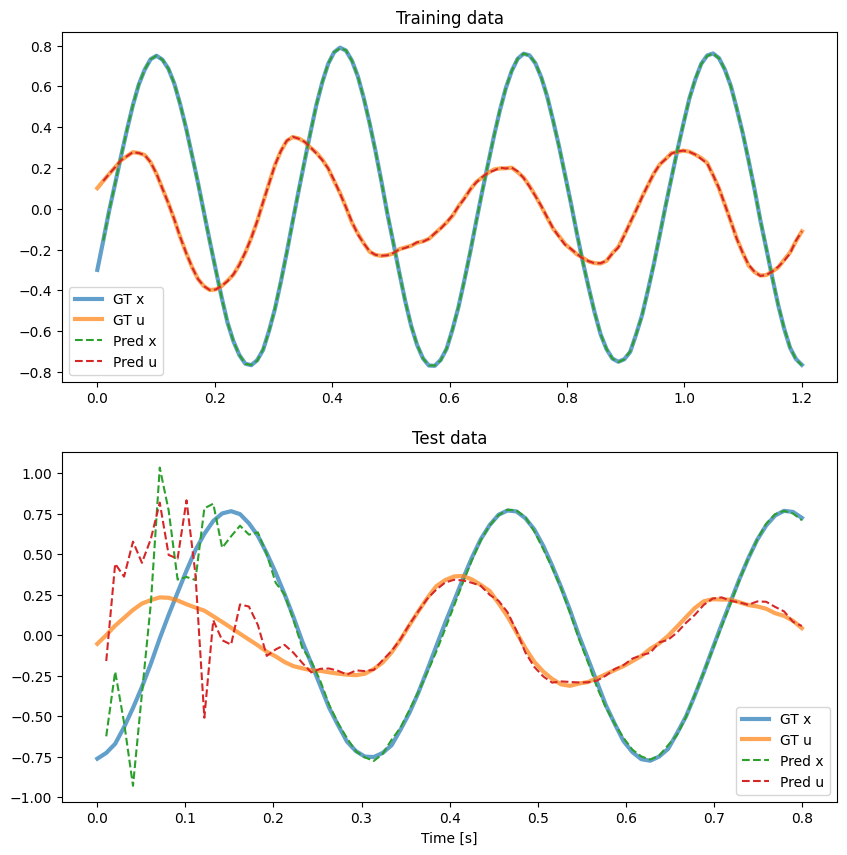

In [35]:


fig, axs = plt.subplots(2, 1, figsize=(10, 10))
for i, (data, preds) in enumerate(zip([train_data, test_data], [train_preds, test_preds])):
    t = np.linspace(0, data.shape[1]/SAMPLE_RATE, data.shape[1])
    axs[i].plot(t, data[0, :], label='GT x', linewidth=3, alpha=0.7)
    axs[i].plot(t, data[1, :], label='GT u', linewidth=3, alpha=0.7)
    axs[i].plot(t[1:], preds.T[0, :], label='Pred x', linestyle='--')
    axs[i].plot(t[1:], preds.T[1, :], label='Pred u', linestyle='--')
    axs[i].legend()

axs[1].set_xlabel('Time [s]')
axs[0].set_title('Training data')
axs[1].set_title('Test data')
plt.show()


We can see the warmup period introducing quite a lot of error initialy for the test data. No lets calculate the MSE

In [36]:
def calc_mse(gt, pred):
    return np.mean((gt - pred)**2)

train_mse = calc_mse(train_data[:, 1:].T, train_preds)
test_mse = calc_mse(test_data[:, 1:].T, test_preds)

print(f'Training MSE: {train_mse}')
print(f'Test MSE: {test_mse}')

Training MSE: 3.2274583856522397e-06
Test MSE: 0.028056203390100592


## 2.3
Let's perform a grid search over the hyperparameters and select those which minimize the training loss. There are two hyperparameters, hidden_size and spectral radius.


In [37]:
def esn_gridsearch(hidden_sizes:List, spectral_radius:List):
    # mse matrix to store the mse values for each combination of hidden size and spectral radius
    train_mse_mat = np.ones((len(hidden_sizes), len(spectral_radius)))*np.inf
    test_mse_mat = np.copy(train_mse_mat)

    for i, hs in tqdm(enumerate(hidden_sizes), desc="grid search progress"):
        for j, sr in enumerate(spectral_radius):
            W, W_in = create_reservoir(size=hs, in_size=2, spectral_radius=sr)
            hidden = run_reservoir(W, W_in, train_data[:, :-1].T)
            W_out = train_reservoir(hidden, train_data[:, 1:].T)
            train_preds = predict_reservoir(W_out, W, W_in, train_data[:, :-1].T)
            test_preds = predict_reservoir(W_out, W, W_in, test_data[:, :-1].T)
            # calculating mse
            train_mse = calc_mse(train_data[:, 1:].T, train_preds)
            test_mse = calc_mse(test_data[:, 1:].T, test_preds)
            train_mse_mat[i, j] = train_mse
            test_mse_mat[i, j] = test_mse

    opt_hs, opt_sr = np.unravel_index(np.argmin(train_mse_mat), train_mse_mat.shape)

    return train_mse_mat, test_mse_mat

let's perform the grid search and visualise the mse matrix

In [38]:
def plot_mse_mat(ax, mse_mat, hs_list, sr_list, norm=LogNorm()):
    cax = ax.matshow(mse_mat, cmap='jet', norm=norm)
    # formatting 
    ax.set_xticks(np.arange(0, len(sr_list), 2))
    ax.set_xticklabels([f'{sr_list[k]:.2f}' for k in range(0, len(sr_list), 2)])
    ax.set_yticks(np.arange(len(hs_list)))
    ax.set_yticklabels([f'{hs}' for hs in hs_list])
    ax.set_xlabel('Spectral radius')
    ax.set_ylabel('Hidden size')

    return cax

grid search progress: 10it [00:03,  2.93it/s]


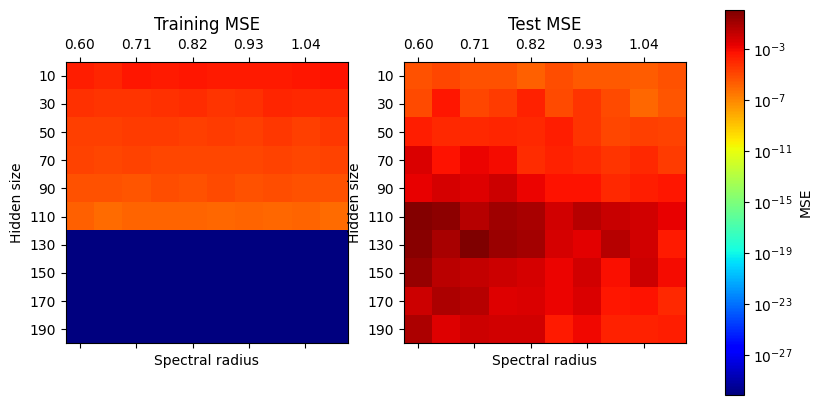

In [39]:
hs_list = np.arange(10, 210, 20)
sr_list = np.linspace(0.6, 1.1, 10)

train_mse, test_mse = esn_gridsearch(hs_list, sr_list)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# combined norm so that a single colorbar can be used
combined = np.vstack([train_mse, test_mse]).flatten()
norm = LogNorm(vmin=np.min(combined), vmax=np.max(combined))

for i, mat in enumerate([train_mse, test_mse]):
    cax = plot_mse_mat(axs[i], mat, hs_list, sr_list, norm=norm)

fig.colorbar(cax, ax=axs, label='MSE')
axs[0].set_title('Training MSE')
axs[1].set_title('Test MSE')
plt.show()

We can see from comparing the train and test MSE grid search matrix that there is actually fairly poor correspondence between the train and test data performance for different hyperparameters. It seems that above a hidden size of 110, the model is completely over fit to the training data as it does poorly on the test data, but perfectly on the train data. If we were to select from the test data a small grid size is actually optimal. Let's constrict the grid size to smaller values and visualise one more test_mse, then select from the test_mse instead. We'd be more likely to find optimal hyperparameters with a training and testing set containing multiple timeseries, but this would be more expensive to compute. To make the grid_search less expensive we could use a random grid search instead of exhaustively searching each hyperparameter.

grid search progress: 9it [00:00, 60.41it/s]


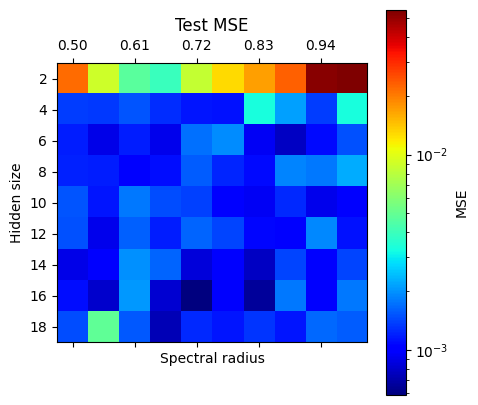

Best hidden size: 16
Best spectral radius: 0.7222222222222222


In [40]:
hs_list = np.arange(2, 20, 2)
sr_list = np.linspace(0.5, 1, 10)
_, test_mse = esn_gridsearch(hs_list, sr_list)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
cax = plot_mse_mat(ax, test_mse, hs_list, sr_list)
fig.colorbar(cax, ax=ax, label='MSE')
ax.set_title('Test MSE')
plt.show()

# best hyperparameters
best_hs, best_sr = np.unravel_index(np.argmin(test_mse), test_mse.shape)

print(f'Best hidden size: {hs_list[best_hs]}')
print(f'Best spectral radius: {sr_list[best_sr]}')

## 2.4
Now lets retrain on the entire dataset using the hyperparameters from the grid_search.

In [ ]:
def train_test_split(train_ratio, size, val_ratio=0):
    """
    splits the full dataset into training and test sets

    args:
    ------
    train_ratio : float
        The ratio of the dataset to use for training
    size : int
        The size of the dataset
    val_ratio : float, optional (default is 0)
        The ratio of the dataset to use for validation

    returns:
    --------
    train_inds : ndarray
        The indices of the training set
    test_inds : ndarray
        The indices of the test set
    val_inds : ndarray
        The indices of the validation set (if val_ratio > 0)
    """
    # again let's do a 60-40 split, this time splitting by trial
    split_pos = round(train_ratio*size)
    random_inds = np.random.permutation(size)
    train_inds = random_inds[:split_pos]
    test_inds = random_inds[split_pos:]

    if val_ratio > 0:
        val_pos = round(val_ratio*size)
        val_inds = test_inds[:val_pos]
        test_inds = test_inds[val_pos:]

        return train_inds, test_inds, val_inds
    
    return train_inds, test_inds


train_inds, test_inds = train_test_split(0.6, X.shape[0])

train_data = np.vstack([X[train_inds, :].flatten(), U[train_inds, :].flatten()])
test_data = np.vstack([X[test_inds, :].flatten(), U[test_inds, :].flatten()])


print(train_data.shape, test_data.shape)

(2, 13000) (2, 8600)


In [42]:
W_in, W, W_out = train_esn(best_hs, best_sr, train_data, test_data)

train_preds = predict_reservoir(W_out, W, W_in, train_data[:, :-1].T)
test_preds = predict_reservoir(W_out, W, W_in, test_data[:, :-1].T)

train_mse = calc_mse(train_data[:, 1:].T, train_preds)
test_mse = calc_mse(test_data[:, 1:].T, test_preds)

print(f'Training MSE: {train_mse}')
print(f'Test MSE: {test_mse}')

Training MSE: 0.08303777684573722
Test MSE: 0.05793714427114317


we see after training on the whole dataset, that the training MSE is quite a bit worse, but noteably the testing accuracy is more than an order of magnitude better, suggesting that after the hyperparameter search the ESN is able to generalise well on the training data. In order to generalise this well, it is likely that the ESN network would have to learn the cubic relationship seen between displacement amplitude and force amplitude. We can test this hypothesis, by calculating the standard deviations of the model predictions and plotting this against that of the ground truth data.

(2, 21598)
107.99


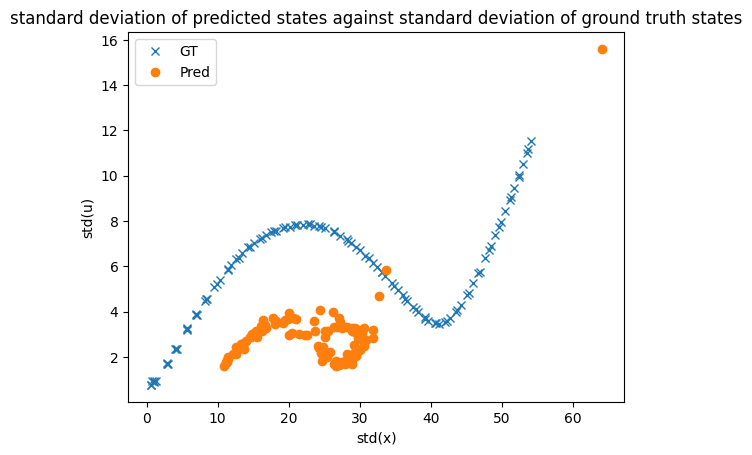

In [43]:
all_preds = np.hstack([train_preds.T, test_preds.T])
print(all_preds.shape)
print(all_preds.shape[1] / 200)

all_preds[0, :] *= X_max
all_preds[1, :] *= U_max

X_pred_std = []
U_pred_std = []
for i in range(round(all_preds.shape[1]/200)):
    time_series = all_preds[:, i*200:(i+1)*200]
    X_pred_std.append(np.std(time_series[0, :]))
    U_pred_std.append(np.std(time_series[1, :]))

plt.plot(X_std, U_std, "x", label='GT')
plt.plot(X_pred_std, U_pred_std, 'o', label='Pred')
plt.xlabel('std(x)')
plt.ylabel('std(u)')
plt.title('standard deviation of predicted states against standard deviation of ground truth states')
plt.legend()
plt.show()

We can see from this recreation of the plot in question 1, that the ESN has learned a remarkably good fit to the data. This is quite astounding when you consider that the model is achieving this by learning a single fully connected layer between the random hidden activations of the ESN and the output. Clearly the random reccurent dynamics of the ESN are able to capture this cubic relationship in a manner that can be extracted by a linear fit.

## Problem 3 - RNNs

## 3.1
Since we are no training a deeper network, it makes sense to use a train-test-val split so that we can implement early stopping during training, to avoid overfitting.
We will keep the proportion of training data the same, so that we have a 60-20-20 train-test-val split.

TypeError: type numpy.ndarray doesn't define __round__ method

## 3.2 and 3.3

We can use the Pytorch implementation of a vanilla RNN and create a RNN_Net class as a wrapper, which implements a fully connected output layer, to make predictions from the hidden layer activations.

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

class RNN_Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True, num_layers=1, nonlinearity='relu', bias=True, device=DEVICE)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, return_hidden=False):
        out, hidden = self.rnn(x)
        out = self.fc(out)
        
        if return_hidden:
            return out, hidden
        return out


Training Script

In [ ]:
def train_RNN(net, train_data, test_data)